In [6]:
!pip install monai

In [7]:
!pip install 'monai[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil, cucim, openslide, pandas, einops, transformers, mlflow, matplotlib, tensorboardX, tifffile, imagecodecs, pyyaml, fire, jsonschema, pynrrd, pydicom, h5py]'


In [8]:
import logging
import os
import shutil
import sys
import tempfile
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter


import monai
from monai.data import CacheDataset, Dataset, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Resized,
    EnsureChannelFirstd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    DataStats,
    Spacingd,
    AsDiscreted,
    LabelToMaskd,
    RandRotate90d,
    EnsureType,
    SaveImaged,
    Invertd,
    EnsureTyped,
    ToTensord,
    RandAffined,
    EnsureTyped,
    CenterSpatialCropd    

)
from monai.utils import first, set_determinism
from monai.losses import DiceLoss,DiceCELoss
from monai.networks.nets import UNet, UNETR, SwinUNETR
from monai.networks.layers import Norm

#%%
"""Set determinism per un training ripetibile"""

SEED = 33  
set_determinism(SEED)

"""Dictionaries"""
#%%================================= CARTELLE DA CAMBIARE =====================
directory= '/kaggle/input/dataset-3d-hm'
directory_img = '/kaggle/input/dataset-3d-NUOVO-hm'

train_IMG_path = sorted(glob(os.path.join(directory_img,'imagesTr-coscia','*.nii')))
train_MASK_path = sorted(glob(os.path.join(directory,'labelsTr-coscia','*.nii')))


val_IMG_path = sorted(glob(os.path.join(directory_img,'imagesVl-coscia','*.nii')))
val_MASK_path = sorted(glob(os.path.join(directory,'labelsVl-coscia','*.nii')))

#estrarre i path di immagini e maschere manuali del test set
#test_IMG_path = sorted(glob(os.path.join(directory,'imagesTs-coscia','*.nii')))
#test_MASK_path = sorted(glob(os.path.join(directory,'labelsTs-coscia','*.nii')))


In [9]:
model_dir = '/kaggle/working/'

if not os.path.exists(model_dir):
  os.mkdir(model_dir)
#%%

train_files = [{"image": image_name, "label": mask_name} for image_name,mask_name in zip(train_IMG_path,train_MASK_path)]
val_files = [{"image": image_name, "label": mask_name} for image_name,mask_name in zip(val_IMG_path,val_MASK_path)]
#test_files = [{"image": image_name, "label": mask_name} for image_name,mask_name in zip(test_IMG_path,test_MASK_path)]

"""Pre-processing"""

#trasformazione del training
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
              1.0938,1.0938 ,5.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96,96,32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
       
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ] )      


#trasformazioni del validation
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.0938,1.0938 ,5.0), mode=("bilinear", "nearest"))
       
        
    
    ]
)

"""Applicare le trasformazioni"""

train_ds = Dataset(train_files , train_transforms)
#train_loader = DataLoader( train_ds, batch_size=1)
train_loader = DataLoader( train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = Dataset(val_files , val_transforms)
val_loader = DataLoader( val_ds, batch_size=1)

"""Visualizzare un esempio """

#train_patient = first(train_loader)

#print(train_patient["image"].shape,train_patient["label"].shape)

#slice_n = 15

#plt.figure('prova',(12,6))


# plt.subplot(1,2,1)
# plt.title('FILE TRASFORMATO')
# plt.imshow(train_patient["image"][0,0,:,:,slice_n],cmap='gray')

# plt.subplot(1,2,2)
# plt.title('Segmentazione')
# plt.imshow(train_patient["label"][0,0,:,:,slice_n])

# plt.show()
#%% creare il modello


'Visualizzare un esempio '

In [10]:

"""Creazione della cartella in cui salvare il modello , se non esiste già

"""


"""
* Model
* Optimizer
* Loss function
* Dice metric

"""
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:128'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
#model = SwinUNETR(
#     img_size=(96,96, 32),   
#     in_channels=1,
#     out_channels=13,
#     feature_size=24,
#     use_checkpoint=True,
# ).to(device)

model = UNet(
    spatial_dims=3,
    in_channels=1,
   out_channels=13,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

#model.load_state_dict(torch.load(
 #    os.path.join(model_dir, "best_metric_model_SwinUNETR_coscia.pth")))

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)    #softmax è per quella multiclasse. segmentazione binaria è meglio sigmoid
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

#%%

"""Standard Pytorch training"""

max_epochs = 350
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([Activations(softmax=True),AsDiscrete(argmax=True, to_onehot=13)])
post_label = Compose([AsDiscrete(to_onehot=13)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:   
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:     
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (96,96,32)  
                sw_batch_size = 2
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
               
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)


            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    model_dir, "best_metric_model_UNET_coscia_MAMMA.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            

----------
epoch 1/350
1/43, train_loss: 3.8086
2/43, train_loss: 3.7903
3/43, train_loss: 3.7464
4/43, train_loss: 3.7374
5/43, train_loss: 3.7086
6/43, train_loss: 3.6877
7/43, train_loss: 3.6519
8/43, train_loss: 3.6108
9/43, train_loss: 3.5805
10/43, train_loss: 3.5781
11/43, train_loss: 3.5363
12/43, train_loss: 3.5226
13/43, train_loss: 3.4838
14/43, train_loss: 3.4921
15/43, train_loss: 3.4369
16/43, train_loss: 3.4253
17/43, train_loss: 3.3838
18/43, train_loss: 3.3666
19/43, train_loss: 3.3237
20/43, train_loss: 3.3182
21/43, train_loss: 3.3054
22/43, train_loss: 3.2788
23/43, train_loss: 3.2886
24/43, train_loss: 3.2421
25/43, train_loss: 3.2169
26/43, train_loss: 3.2577
27/43, train_loss: 3.1524
28/43, train_loss: 3.1490
29/43, train_loss: 3.0940
30/43, train_loss: 3.1161
31/43, train_loss: 3.1039
32/43, train_loss: 3.0766
33/43, train_loss: 3.0476
34/43, train_loss: 3.2182
35/43, train_loss: 3.1305
36/43, train_loss: 3.0552
37/43, train_loss: 3.0254
38/43, train_loss: 2.953

train completed, best_metric: 0.8088 at epoch: 347


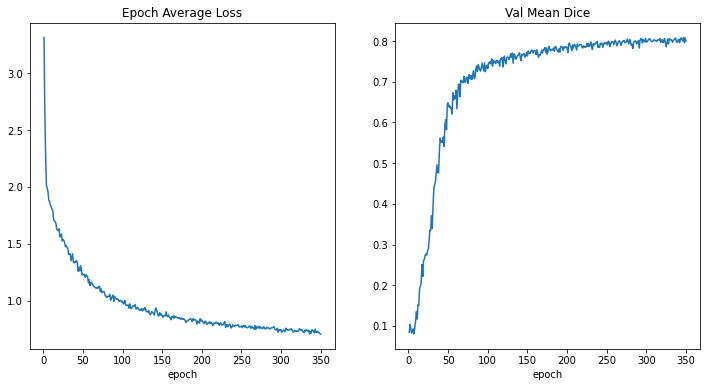

In [11]:


#%%   VISUALIZZAZIONE

"""Visualizzazione Loss e Metrics"""

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")



plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()



In [12]:
#model_dir = '/kaggle/working/MODEL-COSCIA'
#working_dir = '/kaggle/working/'

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #
#model = UNet(
 #   spatial_dims=3,
 #   in_channels=1,
 #   out_channels=13,
 #   channels=(16, 32, 64, 128, 256),
 #   strides=(2, 2, 2, 2),
 #   num_res_units=2,
 #   norm=Norm.BATCH,
#).to(device)

#model.load_state_dict(torch.load(
 #    os.path.join(model_dir, "best_metric_model_SwinUNETR_coscia.pth")))
#torch.save(model.state_dict(), os.path.join(
 #                   working_dir, "best_metric_model_SwinUNETR_coscia3.pth"))

In [13]:
#model_dir = '/kaggle/working/MODEL-COSCIA'
#working_dir = '/kaggle/working/'

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #
#model = SwinUNETR(
 #   img_size=(96,96, 32),   
 #   in_channels=1,
 #   out_channels=13,
 #   feature_size=24,
 #   use_checkpoint=True,
#).to(device)

#model.load_state_dict(torch.load(
 #    os.path.join(model_dir, "best_metric_model_SwinUNETR_coscia.pth")))
#torch.save(model.state_dict(), os.path.join(
 #                   working_dir, "best_metric_model_SwinUNETR_coscia.pth"))